## 순환 신경망 이해하기
지금까지 사용한 신경망의 특징은 메모리가 없다는 것  
-> 네트워크에 주입되는 입력은 개별적으로 처리되며 입력 간에 유지되는 상태가 없음  
-> 전체 시퀀스를 하나의 데이터 포인트로 변환해야 함  

이전에 다뤘던 [IMDB 문제에서](https://nuyhc.github.io/deep%20learning/06_Text_Seq_intro/) 영화 리뷰 하나를 큰 벡터 하나로 변환해 처리  
-> 피드포워드 네트워크(feedforward network)  

사람이 문장을 읽는 것처럼 이전에 나온 것을 기억하면서 단어별로 또는 한눈에 들어오는 만큼씩 처리 가능  
-> 문장에 있는 의미를 자연스럽게 표현하도록 도와줌  
-> 극단적으로 단순화시킨 버전이 **순환 신경망(Recurrent Neural Network, RNN)** 임  

### RNN
시퀀스의 원소를 순회하면서 처리한 정보를 **상태(state)** 에 저장  
-> 내부에 루프(loop)를 갖는 신경망의 한 종류  
-> RNN의 상태는 2개의 다른 시퀀스를 처리하는 사이에 재설정

In [2]:
# 간단한 RNN 정방향 계산
import numpy as np

timesteps = 100 # 입력 시퀀스에 있는 타임스텝의 수
input_features = 32 # 입력 특성의 차원
output_features = 64 # 출력 특성의 차원

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features)) # 초기 상태

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_sequence = np.stack(successive_outputs, axis=0)

In [3]:
inputs

array([[0.67098837, 0.23079513, 0.5434262 , ..., 0.38224125, 0.12011091,
        0.73089334],
       [0.0635489 , 0.21060464, 0.18464099, ..., 0.9319654 , 0.70419988,
        0.99186618],
       [0.71294759, 0.80994589, 0.59336463, ..., 0.41221243, 0.94641304,
        0.80857509],
       ...,
       [0.15169463, 0.05481793, 0.09322618, ..., 0.19277811, 0.65211067,
        0.66327736],
       [0.39092047, 0.48841211, 0.57573274, ..., 0.75254004, 0.1780303 ,
        0.99936919],
       [0.83775412, 0.62877041, 0.70264666, ..., 0.15496044, 0.24446017,
        0.16436489]])

In [4]:
final_output_sequence

array([[0.99999722, 0.99999993, 0.99999832, ..., 0.99999996, 1.        ,
        0.99999995],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

#### 케라스의 순환층
위에서 넘파이로 작성한 코드는 실제 케라스의 `SimpleRNN` 층에 해당  
-> 출력은 모은 전체 시퀀스를 반환하거나, 입력 시퀀스에 대한 마지막 출력만 반환할 수 있음

In [2]:
# SimpleRNN을 사용해 마지막 타임스탬프의 출력만 얻는 예제
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

C:\Users\spec3\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
# 전체 시퀀스를 반환하는 예제
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


#### IMDB 데이터에 RNN 적용하기

In [1]:
from keras.datasets import imdb
from tensorflow.keras.utils import pad_sequences

max_features = 10000
maxlen = 500
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print(f"훈련 시퀀스: {len(input_train)}\n테스트 시퀀스: {len(input_test)}")

input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)

print(f"input_train: {input_train.shape}\ninput_test: {input_test.shape}")

훈련 시퀀스: 25000
테스트 시퀀스: 25000
input_train: (25000, 500)
input_test: (25000, 500)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN
import tensorflow as tf

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["acc"]
)

with tf.device(":/GPU:0"):
    hist = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 122s 763ms/step - loss: 0.5449 - acc: 0.7173 - val_loss: 0.3924 - val_acc: 0.8340
Epoch 2/10
157/157 [==============================] - 125s 799ms/step - loss: 0.3704 - acc: 0.8464 - val_loss: 0.3747 - val_acc: 0.8424
Epoch 3/10
157/157 [==============================] - 125s 799ms/step - loss: 0.2407 - acc: 0.9066 - val_loss: 0.3586 - val_acc: 0.8522
Epoch 4/10
157/157 [==============================] - 125s 800ms/step - loss: 0.1595 - acc: 0.9424 - val_loss: 0.4100 - val_acc: 0.8246
Epoch 5/10
157/157 [==============================] - 128s 813ms/step - loss: 0.1080 - acc: 0.9667 - val_loss: 0.3873 - val_acc: 0.8568
Epoch 6/10
157/157 [==============================] - 121s 770ms/step - loss: 0.0633 - acc: 0.9808 - val_loss: 0.4420 - val_acc: 0.8432
Epoch 7/10
157/157 [==============================] - 116s 739ms/step - loss: 0.0420 - acc: 0.9890 - val_loss: 0.5101 - val_acc: 0.8216
Epoch 8/10
157/157 [============================

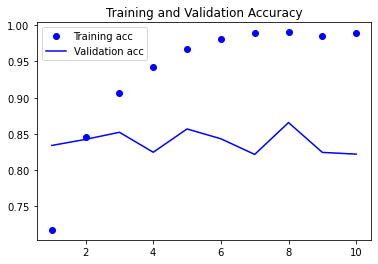

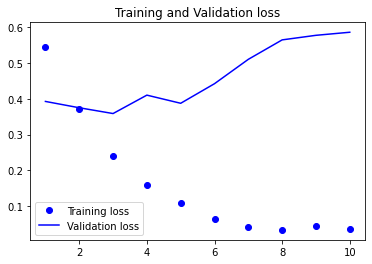

In [7]:
import matplotlib.pyplot as plt

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

전체 시퀀스가 아니라 순서대로 500개의 단어만 입력에 사용했기 때문에 성능이 좋은 편은 아님  
-> `SimpleRNN`이 긴 시퀀스를 처리하는데 적합한 층이 아니기 때문

### LSTM과 GRU 층
`SimpleRNN` 외에 다른 순환 층으로, 실제 많이 사용되는 순환층들임  


`SimpleRNN`은 이론적으로 시간 t에서 이전의 모든 타임스텝의 정보를 유지할 수 있음  
-> 실제로는 긴 시간에 걸친 의존성을 학습할 수 없는 문제가 있음  
-> 층이 많은 일반 네트워크(피드포워드 네트워크)에서 나타나는 것과 비슷한 현상인 **그래디언트 소실 문제(vanishing gradient problem)** 때문  
-> LSTM과 GRU층으로 해결

#### LSTM(Long Short-Trem Memory)
`SimpleRNN`의 변종으로, 여러 타임스텝에 걸쳐 나르는 방법이 추가됨  
-> 나중을 위해 정보를 저장함으로써 처리 과정에서 오래된 시그널이 점차 손실되는 것을 막아줌  

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import tensorflow as tf

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["acc"]
)

with tf.device(":/GPU:0"):
    hist = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 19s 27ms/step - loss: 0.5186 - acc: 0.7528 - val_loss: 0.3503 - val_acc: 0.8536
Epoch 2/10
157/157 [==============================] - 4s 24ms/step - loss: 0.3001 - acc: 0.8813 - val_loss: 0.3621 - val_acc: 0.8580
Epoch 3/10
157/157 [==============================] - 4s 26ms/step - loss: 0.2389 - acc: 0.9099 - val_loss: 0.3194 - val_acc: 0.8642
Epoch 4/10
157/157 [==============================] - 4s 25ms/step - loss: 0.2020 - acc: 0.9254 - val_loss: 0.2874 - val_acc: 0.8850
Epoch 5/10
157/157 [==============================] - 4s 27ms/step - loss: 0.1797 - acc: 0.9358 - val_loss: 0.3162 - val_acc: 0.8700
Epoch 6/10
157/157 [==============================] - 4s 26ms/step - loss: 0.1618 - acc: 0.9424 - val_loss: 0.4015 - val_acc: 0.8738
Epoch 7/10
157/157 [==============================] - 4s 25ms/step - loss: 0.1451 - acc: 0.9486 - val_loss: 0.3414 - val_acc: 0.8846
Epoch 8/10
157/157 [==============================] - 4s 25ms/step -

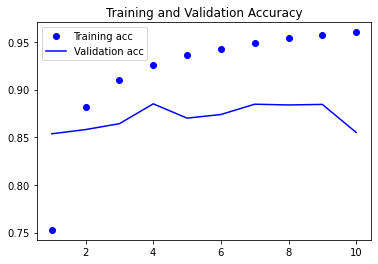

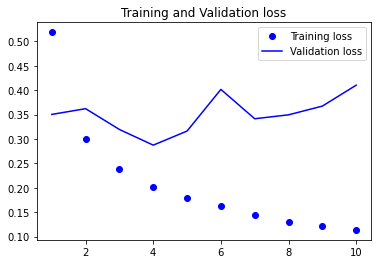

In [3]:
import matplotlib.pyplot as plt

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

### 순환 신경망의 고급 사용법
1. 순환 드롭아웃(recurrent dropout): 순환층에서 과대적합을 방지하기 위해 사용
2. 스태킹 순환층(stacking recurrent layer): 네트워크의 표현 능력(representational power)을 증가 (계산 비용 증가)
3. 양방향 순환층(bidirectional recurrent layer): 순환 네트워크에 같은 정보를 다른 방향으로 주입해 정확도를 높이고 기억을 좀 더 오래 유지

#### 기온 예측 문제
14개의 관측치가 10분 간격으로 기록되어있음  

In [4]:
import os

data_dir = "./"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

f = open(fname)
data = f.read()
f.close()

In [5]:
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

In [6]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [9]:
print(len(lines))

420451


In [10]:
# 데이터 파싱
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i,:] = values

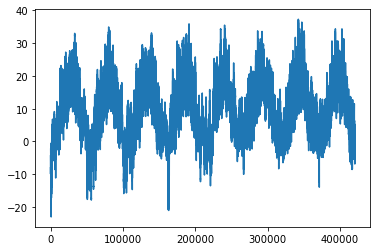

In [11]:
# 시계열 온도 그래프
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp);

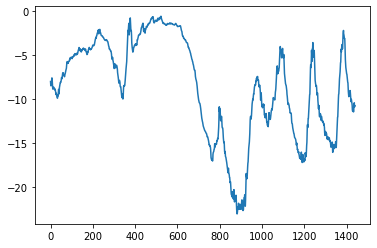

In [13]:
# 처음 10일간 온도 그래프
plt.plot(range(1440), temp[:1440]);

In [ ]:
# 데이터 정규화
mean = 